In [429]:
# Import necessary libraries for preprocessing
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, root_mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import PartialDependenceDisplay
import math

'''The point of this section is to A) import the dataset, B) drop unecessary columns (assuming you need to), C) rename columns (if you want),
and then D) adjust data types. This file specifically deals with the density values, which were the number of points of interests in a specific radius (one mile, three miles, or five miles) around a housing address.'''

# Load the dataset
#It is also assuming this is a LOCAL file that was downloaded directly to the computer, hence the location. This can be replaced with anything, like a git location. 
Atlanta_Density = pd.read_csv('~/Documents/NYCDSA/Capstone/Density_Atlanta/Density_Atlanta.csv')

#Combine redundant columns. The two baths columns are addressing the same overall feature, they can be combined into "total baths", like "total bedrooms".
#Half baths is multiplied by .5 of a value because it is "half of a full bath"
Atlanta_Density['Total Bathrooms'] = Atlanta_Density['number_of_full_baths'] + (Atlanta_Density['number_of_half_baths']*0.5)

#Drop any columns you aren't analyzing. This was taken from a baseline, where columns to be included were decided later. 
Atlanta_Density = Atlanta_Density.drop(columns=['latitude',
                                                  'longitude', 'number_of_full_baths', 'number_of_half_baths'])

#Rename columns for clarity. 
Atlanta_Density = Atlanta_Density.rename(columns={'SM_One': 'Supermarket (One Mile)', 'C_One': 'Convenience (One Mile)',
'WS_One': 'Wholesale (One Mile)', 'VS_One': 'Variety Store (One Mile)', 'SC_One': 'Supercenter (One Mile)', 'number_of_bedrooms': 'Total Bedrooms', 'living_area_square_feet': 'Living Area(SQF)',
                                                   'lot_size_in_square_feet': 'Lot Size(SQF)', 'number_of_garage_spaces': 'Garage Spaces', 'number_of_stories': 'Stories',
                                                   'SM_Five': 'Supermarket (Five Miles)', 'C_Five': 'Convenience (Five Miles)', 'year_built': 'Year Built',
'WS_Five': 'Wholesale (Five Miles)', 'VS_Five': 'Variety Store (Five Miles)', 'SC_Five': 'Supercenter (Five Miles)',
                                                 'WS_Three': 'Wholesale (Three Miles)', 'VS_Three': 'Variety Store (Three Miles)',
                                                  'SM_Three': 'Supermarket (Three Miles)', 'SC_Three': 'Supercenter (Three Miles)', 'C_Three': 'Convenience (Three Miles)'})

#"Year built" is read as a float OR as a string, it should be read as an integer. For numerical analysis, use int or float if there are missing values, which "year built" has.
Atlanta_Density['Year Built'] = Atlanta_Density['Year Built'].astype('Int64') #For numerical analysis: Use int or float if there are missing values

#We want to group by the street_address because Excel does not order duplicates the same way as Python. So, if this method was done in a different notebook without grouping, the ordering might accidentally be different, causing a different result because of the NAN values.
Atlanta_Density = Atlanta_Density.groupby(["street_address"]).max().reset_index(drop = False)

#We also want to divide this model into three sections: the one mile, the three mile, and the five mile models. So, once it's grouped, create the one mile set with the other values dropped.
Atlanta_Density_One = Atlanta_Density.drop(columns=['Wholesale (Five Miles)', 'Variety Store (Five Miles)', 'Supermarket (Five Miles)', 'Supercenter (Five Miles)', 'Convenience (Five Miles)',
                                                   'Wholesale (Three Miles)','Variety Store (Three Miles)','Supermarket (Three Miles)', 'Supercenter (Three Miles)','Convenience (Three Miles)'])
Atlanta_Density_One

,street_address,current_listing_price,Year Built,Total Bedrooms,Living Area(SQF),Convenience (One Mile),Supercenter (One Mile),Supermarket (One Mile),Variety Store (One Mile),Wholesale (One Mile),Total Bathrooms
0,0 ivy MNR DR NW 0,2865,2002,4,3259.0,0,0,0,0,0,2.5
1,1 10 buena VIS CIR SE,2200,<NA>,3,1993.0,2,1,0,2,0,2.0
2,1 1088 coldwater DR,2000,<NA>,3,1910.0,0,0,0,0,0,2.0
3,1 1130 willivee DR,1995,<NA>,3,1134.0,0,0,0,0,0,1.0
4,1 1307 idlewood CT,2800,<NA>,4,2532.0,0,0,0,0,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
19213,procurement only - 66 4th ST,1600,<NA>,3,1367.0,0,0,0,0,0,2.0
19214,r2188 executive DR,2199,<NA>,3,1696.0,1,0,1,0,0,2.5
19215,r3339 woodward down,2380,2015,3,1944.0,0,1,1,1,1,3.5
19216,singleunit 216 greensprings DR,1900,<NA>,4,1204.0,1,0,0,1,0,2.0


In [430]:
'''We now want to create a pipeline for the one mile dataset, focusing on the numeric features. We begin by selecting just the numeric features, applying a scaler transformer,
and then merging that into a preprocessor'''


# Exclude 'current_listing_price' from features, since this is your target. This will also automatically be excluding street_address, a categorical variable, as that was just being used for grouping.
#You 'could' name these variables as something like 'numeric_features_one', but since it's the first in order, an attribute wasn't applied.
numeric_features = Atlanta_Density_One.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns

In [431]:
# Pipeline for numeric features: Impute missing values using mean (you may also do median), and then use a scaler for the numeric values. 
numeric_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [432]:
# Combined preprocessor for numeric. The preprocessor applies the transformer (filling in the means and scaling the data) to the numeric features. This prevents data leakage
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
])

#Apply preprocessor to original data (this isn't really necessary for this model, but can be useful for others like the MLR)
transformed_data = preprocessor.fit_transform(Atlanta_Density_One)

In [433]:
# Combine all feature names
all_feature_names = list(numeric_features)
all_feature_names

['Year Built',
 'Total Bedrooms',
 'Living Area(SQF)',
 'Convenience (One Mile)',
 'Supercenter (One Mile)',
 'Supermarket (One Mile)',
 'Variety Store (One Mile)',
 'Wholesale (One Mile)',
 'Total Bathrooms']

In [434]:
#Create a dataframe from the applied preprocessor with the list to see the results. This is "technically" not necessary, only if you need to see the data itself.
#You can, however, use this new dataframe as a replacement for for Atlanta_Density_One, assuming current_listing_price was dropped. 
transformed_df = pd.DataFrame(transformed_data, columns=all_feature_names)
transformed_df 

,Year Built,Total Bedrooms,Living Area(SQF),Convenience (One Mile),Supercenter (One Mile),Supermarket (One Mile),Variety Store (One Mile),Wholesale (One Mile),Total Bathrooms
0,5.068264e-01,0.670187,1.319220,-0.380758,-0.231761,-0.527261,-0.416323,-0.093909,0.189453
1,1.073134e-14,-0.440415,0.101174,1.912382,3.692451,-0.527261,2.791734,-0.093909,-0.465279
2,1.073134e-14,-0.440415,0.021318,-0.380758,-0.231761,-0.527261,-0.416323,-0.093909,-0.465279
3,1.073134e-14,-0.440415,-0.725288,-0.380758,-0.231761,-0.527261,-0.416323,-0.093909,-1.774741
4,1.073134e-14,0.670187,0.619757,-0.380758,-0.231761,-0.527261,-0.416323,-0.093909,-0.465279
...,...,...,...,...,...,...,...,...,...
19213,1.073134e-14,-0.440415,-0.501114,-0.380758,-0.231761,-0.527261,-0.416323,-0.093909,-0.465279
19214,1.073134e-14,-0.440415,-0.184576,0.765812,-0.231761,0.847251,-0.416323,-0.093909,0.189453
19215,1.120386e+00,-0.440415,0.054030,-0.380758,3.692451,0.847251,1.187705,10.648608,1.498915
19216,1.073134e-14,0.670187,-0.657940,0.765812,-0.231761,-0.527261,1.187705,-0.093909,-0.465279


In [435]:
'''Next is to create the initial model. This model calls for a train-test-validation split, also called a three-way split. First, the model needs to be defined and
put into the pipeline. Then, the split needs to be defined. This is explained in detail in the code. After this is done, the pipeline should be fit on the training set.
An XGBoost model builds decision trees sequentially, pruning results as it improves upon the mistakes of the previous tree.'''

# Define the full model pipeline including the preprocessor. You can "recall" parts of the pipeline using their string names. 
#For example, if you wanted to just use the model, you'd use 'regressor__' before loading. 
#Random_state is used here to prevent randomization when the model is ran, keeping more consistent results. 
xgb_model = XGBRegressor(random_state=42)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

#1. Split the dataset into a train set and a test set.
#2. Split the training data further into a training set and a validation set.
#3. Use the validation set for tuning, then assess performance on the test set.

X = Atlanta_Density_One.drop(columns='current_listing_price') #This can also be replaced with "transformed_df", as, again, they do the same thing. 
y = Atlanta_Density_One['current_listing_price'] #transformed_df does not have the target, as it's not supposed to be transformed, so it can't be replaced here.

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #This splits your data into 80% (X_train_val) and 20% (X_test)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) #X_train_val data is further split into 60% train set (X_train) and 20% validation (X_val)
#Note: the test_size=0.25 is used to split the remaining training and validation set into 75% training and 25% validation (75% of 80% = 60%)

#The pipeline is fit on the training data and evaluated on the validation set (X_val)
pipeline.fit(X_train, y_train)

#Test Set (X_test): This set is a held-out portion of the data that the model has never seen during training or tuning, making it the best indicator of the model's generalization performance. The test score tells you how well the model is likely to perform on truly unseen data, which is typically the main goal.

#Validation Set (X_val): The validation set is primarily used during model selection and hyperparameter tuning. It gives a good intermediate measure of model performance, but since it has influenced model tuning, it can no longer be considered a truly unbiased assessment of generalization.

#Combined Train-Validation Set (X_train_val): This set is used for final training once the best model has been selected. While scores on this set give an idea of how well the model fits on a larger amount of data, they do not represent true generalization performance, as the data has been used for model tuning and training.

#Training Set (X_train): The training set score can help diagnose underfitting or overfitting during development, but it isn’t relevant as a final evaluation metric because it doesn’t measure how well the model generalizes.

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)',
       'Convenience (One Mile)', 'Supercenter (One Mile)',
       'Supermarket (One Mile)', 'Variety Store (One Mile)',
       'Wholesale (One Mile)', 'Total Bathrooms'],
      dtype='object'))...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [436]:
'''We then "can" calculate the R^2, Mean Squared Error, Root Mean Squared Error, and Mean Absolute Percentage Error for the default sets.
However, these values are typically lower because they aren't tuned.'''

#This is the cross-validation score. A higher R^2 usually means a better model.
#The goal is to have the test score be as close to the train-val score as possible. This score can be used to compare your future model against, but, 
#unless specified, only a tuned model would be preferred since that is supposed to have a higher score

val_score = pipeline.score(X_val, y_val) 
print('Validation R^2:', val_score)

test_score = pipeline.score(X_test, y_test)
print('Test R^2:', test_score)

Validation R^2: 0.4383291006088257
Test R^2: 0.4894154667854309


In [437]:
#This is how you would manually calculate the Mean Squared Error without using some kind of function, using "predict". First, create a y_predict value from the X through the pipeline.
y_val_pred = pipeline.predict(X_val)

#Then, you can calculate the MSE by having the predict value be the new "y value" and the original y value as the x. The lower the score, typically the better the model.
val_mse = mean_squared_error(y_val, y_val_pred)
print('Validation Mean Squared Error:', val_mse)

#To find RMSE, simply square root the MSE
val_rmse = np.sqrt(val_mse)
print("Validation Root Mean Squared Error:", val_rmse)

#This is the same, except it's being done on the test set instead of the validation set. 
y_test_pred = pipeline.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
print('Test Mean Squared Error:', test_mse)
test_rmse = np.sqrt(test_mse)
print("Test Root Mean Squared Error:", test_rmse)

Validation Mean Squared Error: 525147.9729075888
Validation Root Mean Squared Error: 724.6709411226511
Test Mean Squared Error: 430100.54656467267
Test Root Mean Squared Error: 655.8205139858562


In [438]:
#You can calculate MAPE using a function, which then borrows the same variables from the MSE. 
def calculate_mape(actual, predicted):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) between actual and predicted values.

    MAPE is a metric that expresses the prediction error as a percentage of the actual values. 
    It is calculated by taking the average of the absolute percentage differences between the 
    actual and predicted values.

    Parameters:
    ----------
    actual : array-like
        The true target values or ground truth.
    predicted : array-like
        The predicted values from the model.

    Returns:
    -------
    float
        The MAPE value, representing the average percentage error. Lower values indicate better 
        model performance. A perfect score is 0.0, while higher values indicate greater error.
    """
    actual, predicted = np.array(actual), np.array(predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mape

val_mape = calculate_mape(y_val, y_val_pred)
test_mape = calculate_mape(y_test, y_test_pred)

print("Validation Mean Absolute Percentage Error (MAPE):", val_mape)
print("Test Mean Absolute Percentage Error (MAPE):", test_mape) #A lower MAPE value indicates a more accurate prediction

Validation Mean Absolute Percentage Error (MAPE): 17.244166901266105
Test Mean Absolute Percentage Error (MAPE): 16.839769345884278


In [439]:
'''Hyperparameter tuning is used to improve the scores of the default values. First, a grid, or layout, must be created for your model.
Then, you can actually combine all the scoring into one "gridsearch", which is the method we'll use to tune. It is more efficient, but slower than randomized searching.'''


# Create a Stratified KFold object. This is used for cross-validation, taking into account randomization. 
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Define the parameter grid
param_grid = {
    'regressor__n_estimators': [300],       # The number of boosting rounds or trees. Higher values may improve model performance but also increase training time. 
    'regressor__learning_rate': [0.1],     # Controls the impact of each boosting round on the final model. Lower values make learning more gradual and can improve accuracy, though may require more trees.
    'regressor__max_depth': [5],           # Maximum depth of each tree. Limits complexity; lower values reduce overfitting, while higher values can capture more complex patterns.
    'regressor__subsample': [0.8],         # Fraction of the training data used per boosting round. Values below 1.0 can prevent overfitting by introducing randomness.
    'regressor__colsample_bytree': [0.7],  # Fraction of features sampled to train each tree. Lower values prevent overfitting by adding randomness, which can improve generalization.
    'regressor__alpha': [10],              # L1 regularization term on weights, similar to Lasso regression. Helps to make the model simpler by forcing some feature weights to be zero, reducing overfitting.
    'regressor__lambda': [10]                # L2 regularization term on weights, similar to Ridge regression. Helps to make the model more stable and reduces overfitting.
}

# Multi-scoring in GridSearchCV
grid_search = GridSearchCV(pipeline, #Input your pipeline, it's technically using the regressor. This is the 'estimator'
                           param_grid, #Input parameter grid. 
                           cv=kf, #This is the cross-validation, but we're using k-fold, using 10 folds and shuffling it. 
                           scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'], # We're using multiple score, so list out which scoring methods you want to use in brackets.
                           refit='r2', # Specify which metric to refit when it comes to multiple scoring. R2 is used by default.
                           n_jobs=-1) #This just uses all of your computer's processing power.

grid_search.fit(X_train, y_train) #Literally the equivalent of pipeline.fit, but now we're working with the grid_search

best_model = grid_search.best_estimator_ #Best_model is technically irrelevant because the this model is already narrowed down by what the best model is.
#However, if you had multiple models searches, like different numbers for esitmators, it'll find which one leads to the best score. 

# These are just the "highest" results. It's not the validation set. 
results = grid_search.cv_results_
print("Best parameters:", grid_search.best_params_)
print("Best R^2:", grid_search.best_score_)

Best parameters: {'regressor__alpha': 10, 'regressor__colsample_bytree': 0.7, 'regressor__lambda': 10, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 300, 'regressor__subsample': 0.8}
Best R^2: 0.46549606919288633


In [440]:
def calculate_scores(y_true, y_pred):
    """
    Calculate and return multiple regression evaluation metrics.

    This function computes the R² score, Mean Squared Error (MSE), 
    Mean Absolute Percentage Error (MAPE), and Root Mean Squared Error (RMSE) 
    for a set of true values and predicted values, providing a comprehensive 
    evaluation of model performance.

    Parameters:
    ----------
    y_true : array-like
        The true target values.
    y_pred : array-like
        The predicted target values from the model.

    Returns:
    -------
    tuple
        A tuple containing the following scores:
        - r2 : float : R² score, indicating the proportion of variance explained by the model.
        - mse : float : Mean Squared Error, measuring the average squared difference between 
          the predicted and actual values.
        - mape : float : Mean Absolute Percentage Error, showing the average percentage error.
        - rmse : float : Root Mean Squared Error, providing an interpretable measure of 
          prediction error in the original units of the target variable.
    """
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return r2, mse, mape, rmse

In [441]:
'''We now want to create a method to calculate the scores for every set.
Using the previous function, we merely use it against each version of "best model" predicted against each set.'''

#You "can" refit the model on the train_val set under the pretense that it will give a better score. This is assuming there isn't egregious overfitting.
#Refitting the model has the least amount of impact on the test score. 
best_model.fit(X_train_val, y_train_val)

#Applies the function to the val set
y_val_pred_tuned = best_model.predict(X_val)
val_scores = calculate_scores(y_val, y_val_pred_tuned)

#Applies the function to the test set
y_test_pred_tuned = best_model.predict(X_test)
test_scores = calculate_scores(y_test, y_test_pred_tuned)

#Applies the function to the train-val set
y_combined_pred_tuned = best_model.predict(X_train_val)
combined_scores = calculate_scores(y_train_val, y_combined_pred_tuned)

print("Tuned One Mile Validation Set Scores:")
print(f"R²: {val_scores[0]:.4f}")
print(f"MSE: {val_scores[1]:.4f}")
print(f"MAPE: {val_scores[2]:.4f}")
print(f"RMSE: {val_scores[3]:.4f}")

print("\nTuned One Mile Test Set Scores:")
print(f"R²: {test_scores[0]:.4f}")
print(f"MSE: {test_scores[1]:.4f}")
print(f"MAPE: {test_scores[2]:.4f}")
print(f"RMSE: {test_scores[3]:.4f}")

print("\nTuned One Mile Train-Val Set Scores:")
print(f"R²: {combined_scores[0]:.4f}")
print(f"MSE: {combined_scores[1]:.4f}")
print(f"MAPE: {combined_scores[2]:.4f}")
print(f"RMSE: {combined_scores[3]:.4f}")

Tuned One Mile Validation Set Scores:
R²: 0.6300
MSE: 345940.0183
MAPE: 0.1507
RMSE: 588.1667

Tuned One Mile Test Set Scores:
R²: 0.5394
MSE: 387973.6284
MAPE: 0.1613
RMSE: 622.8753

Tuned One Mile Train-Val Set Scores:
R²: 0.6371
MSE: 298231.6637
MAPE: 0.1478
RMSE: 546.1059


In [442]:
'''The next step is to create an identifier for feature importance, usually done through a graph. 
You would take the "best model" and all of its feature names, sort it, and then extract the importance.'''

#This is technically redundant, but what it's recalling the best model from the pipeline.
best_xgb_model = best_model.named_steps['regressor']

#This is getting the feature importances from the best model
feature_importances = best_xgb_model.feature_importances_

#You first sort the feature importances in descending order, then you turn it into an array.
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = np.array(all_feature_names)[sorted_indices]

#This function allows for naming and rounding of the features and the listed importances. The result should show the feature names and their importances, sorted.
for name, importance in zip(sorted_feature_names, sorted_feature_importances):
    print(f"Feature: {name}, Importance: {importance:.4f}")

Feature: Living Area(SQF), Importance: 0.2388
Feature: Total Bathrooms, Importance: 0.2311
Feature: Supermarket (One Mile), Importance: 0.1112
Feature: Convenience (One Mile), Importance: 0.1082
Feature: Year Built, Importance: 0.0964
Feature: Total Bedrooms, Importance: 0.0856
Feature: Variety Store (One Mile), Importance: 0.0617
Feature: Supercenter (One Mile), Importance: 0.0356
Feature: Wholesale (One Mile), Importance: 0.0314


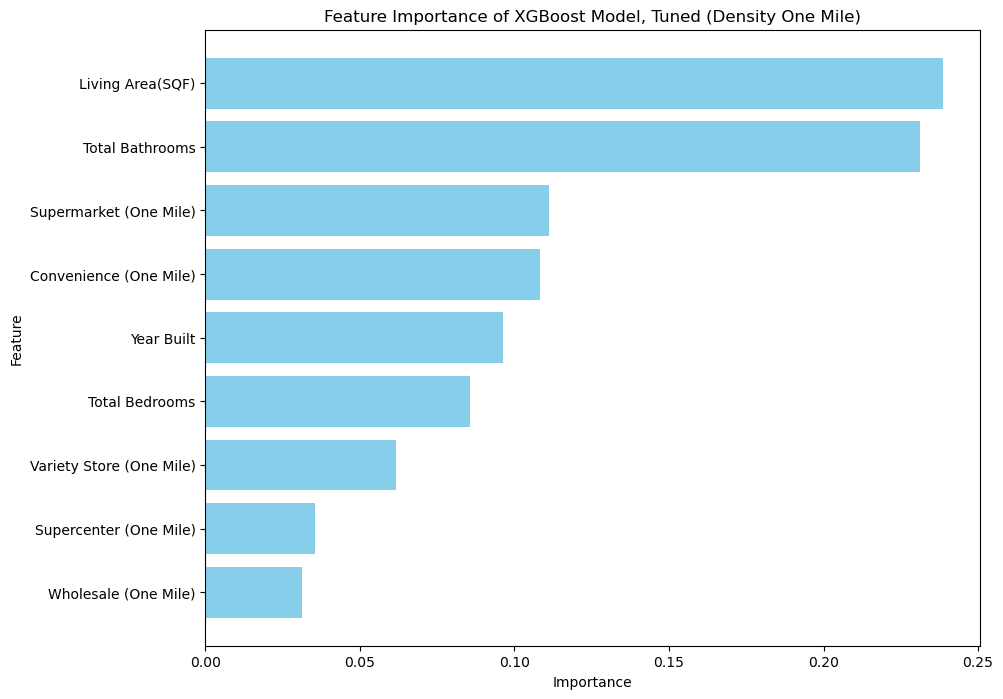

In [443]:
# Create a bar chart for feature importance
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_feature_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of XGBoost Model, Tuned (Density One Mile)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

#The feature importance scores remain consistent regardless of the dataset.

In [444]:
all_feature_names #This was just called as a reminder for the next step. 

['Year Built',
 'Total Bedrooms',
 'Living Area(SQF)',
 'Convenience (One Mile)',
 'Supercenter (One Mile)',
 'Supermarket (One Mile)',
 'Variety Store (One Mile)',
 'Wholesale (One Mile)',
 'Total Bathrooms']

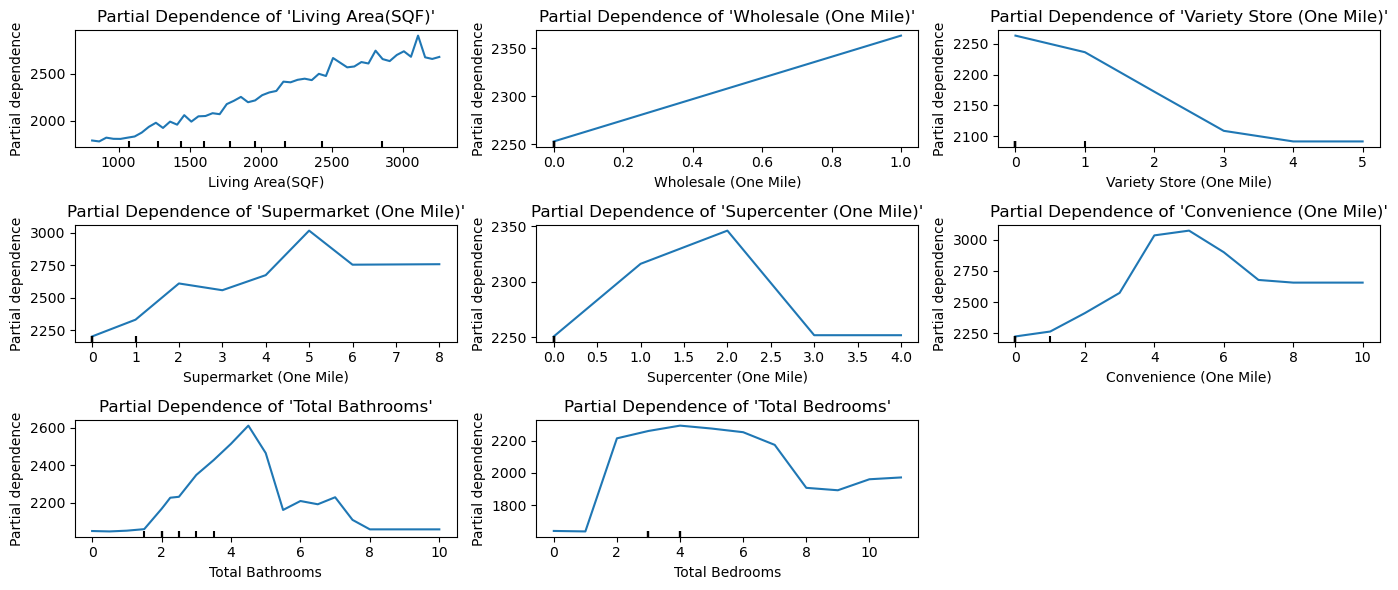

In [445]:
"""
Generates Partial Dependence Plots (PDPs) for specified features to visualize their effect on the model’s predictions. 
Each plot shows the marginal relationship between a feature and the predicted outcome, with all other features averaged out. 
Useful for understanding how changes in individual features impact the model’s predictions.

Parameters:
- best_model: The trained model object from which to generate the PDPs.
- X_train_val: The training (or training-validation) dataset containing feature columns.
- features: A list of feature names (as strings) for which to generate PDPs.
"""

# List of features to include in the Partial Dependence Plots
features = [
 'Living Area(SQF)', 'Wholesale (One Mile)', 'Variety Store (One Mile)', 'Supermarket (One Mile)', 
    'Supercenter (One Mile)', 'Convenience (One Mile)', 'Total Bathrooms', 'Total Bedrooms']

# Set up the grid layout based on the number of features
n_features = len(features)  # Total number of features to plot
n_cols = 3  # Number of columns in the grid layout
n_rows = math.ceil(n_features / n_cols)  # Calculate number of rows needed

# Create a figure with subplots arranged in a grid layout
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, n_rows * 2))
axes = axes.ravel()  # Flatten the axes array to simplify indexing

# Loop through each feature and generate a PDP on a subplot
for i, feature in enumerate(features):
    # Generate the Partial Dependence Plot for the current feature
    PartialDependenceDisplay.from_estimator(
        best_model,
        X_train_val,  # Use the training dataset (or training-validation) for PDP
        [feature],
        grid_resolution=50,  # Resolution of the grid for smoothness of the PDP
        ax=axes[i]  # Place the plot on the specified subplot axis
    )
    axes[i].set_title(f"Partial Dependence of '{feature}'")  # Set a title for each plot

# Hide any empty subplots if the grid is larger than the number of features
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to ensure subplots do not overlap and labels are clear
plt.tight_layout()
plt.show()

In [446]:
'''Because we're dividing the datasets into three seperate models, we now want to essentially copy the design of the previous model, except now use it on the "three mile" features'''

#Take from the original dataset and drop the one mile and five miles features, instead of the three miles and five miles.
Atlanta_Density_Three = Atlanta_Density.drop(columns=['Wholesale (One Mile)', 'Variety Store (One Mile)', 'Supermarket (One Mile)', 'Supercenter (One Mile)', 'Convenience (One Mile)',
                                                      'Wholesale (Five Miles)', 'Variety Store (Five Miles)', 'Supermarket (Five Miles)', 'Supercenter (Five Miles)', 'Convenience (Five Miles)'])

#Create a new numeric features, including just the three miles values.
numeric_features_three = Atlanta_Density_Three.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns

# Our transformer is identical compared to the one mile model, so that can be used, but it needs the new numeric features. 
preprocessor_three = ColumnTransformer(
    transformers=[
        ('num3', numeric_transformer, numeric_features_three),
])

#Apply preprocessor to original data. Again, not necessary, but it would need to be done again because there's new features.
transformed_data_three = preprocessor_three.fit_transform(Atlanta_Density_Three)

In [447]:
# Combine all feature names
all_feature_names_three = list(numeric_features_three)

#Create dataframe
transformed_df_three = pd.DataFrame(transformed_data_three, columns=all_feature_names_three)

In [448]:
#Our model is the same as the one mile model, so that can be used here. However, we do need to specify a new preprocessor since that has new features. 
pipeline_three = Pipeline([
    ('preprocessor3', preprocessor_three),
    ('regressor', xgb_model)
])

#Everything has to have a new variable and be refitted because it's now being applied to a "new" set of features. 
X_three = Atlanta_Density_Three.drop(columns='current_listing_price')
y_three = Atlanta_Density_Three['current_listing_price']

X_train_val_three, X_test_three, y_train_val_three, y_test_three = train_test_split(X_three, y_three, test_size=0.2, random_state=42)
X_train_three, X_val_three, y_train_three, y_val_three = train_test_split(X_train_val_three, y_train_val_three, test_size=0.25, random_state=42)

# Fit the model pipeline
pipeline_three.fit(X_train_three, y_train_three)

Pipeline(steps=[('preprocessor3',
                 ColumnTransformer(transformers=[('num3',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)',
       'Wholesale (Three Miles)', 'Variety Store (Three Miles)',
       'Supermarket (Three Miles)', 'Supercenter (Three Miles)',
       'Convenience (Three Miles)', 'Total Bathrooms']...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [449]:
#Our previous scores were Validation 0.4383291006088257 and Test 0.4894154667854309, for comparison. We can already see a steady rise in score as the radius increases. 

val_score_three = pipeline_three.score(X_val_three, y_val_three)
print('Validation R^2:', val_score_three)

test_score_three = pipeline_three.score(X_test_three, y_test_three)
print('Test R^2:', test_score_three)

Validation R^2: 0.5902328491210938
Test R^2: 0.5791043043136597


In [450]:
#The grid has to be changed because the values changed.
param_grid_three = {
    'regressor__n_estimators': [400],       
    'regressor__learning_rate': [0.1],     
    'regressor__max_depth': [5],                
    'regressor__subsample': [0.8],               
    'regressor__colsample_bytree': [0.7],        
    'regressor__alpha': [20],
    'regressor__lambda': [20]               
}

grid_search_three = GridSearchCV(pipeline_three,
                           param_grid_three,
                           cv=kf,
                           scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],# Multiple scoring
                           refit='r2',
                           n_jobs=-1)

grid_search_three.fit(X_train_three, y_train_three)

best_model_three = grid_search_three.best_estimator_

# Access the results
results_three = grid_search_three.cv_results_
print("Best parameters:", grid_search_three.best_params_)
print("Best R^2:", grid_search_three.best_score_)

Best parameters: {'regressor__alpha': 20, 'regressor__colsample_bytree': 0.7, 'regressor__lambda': 20, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 400, 'regressor__subsample': 0.8}
Best R^2: 0.5647983849048615


In [451]:
#Note how this model is overfitted slightly less than the previous model with the somewhat similar parameters, yet its score is still higher. 
best_model_three.fit(X_train_three, y_train_three)

y_val_pred_tuned_three = best_model_three.predict(X_val_three)
val_scores_three = calculate_scores(y_val_three, y_val_pred_tuned_three)

y_test_pred_tuned_three = best_model_three.predict(X_test_three)
test_scores_three = calculate_scores(y_test_three, y_test_pred_tuned_three)

y_combined_pred_tuned_three = best_model_three.predict(X_train_val_three)
combined_scores_three = calculate_scores(y_train_val_three, y_combined_pred_tuned_three)

print("Tuned Three Miles Validation Set Scores:")
print(f"R²: {val_scores_three[0]:.4f}")
print(f"MSE: {val_scores_three[1]:.4f}")
print(f"MAPE: {val_scores_three[2]:.4f}")
print(f"RMSE: {val_scores_three[3]:.4f}")

print("\nTuned Three Miles Test Set Scores:")
print(f"R²: {test_scores_three[0]:.4f}")
print(f"MSE: {test_scores_three[1]:.4f}")
print(f"MAPE: {test_scores_three[2]:.4f}")
print(f"RMSE: {test_scores_three[3]:.4f}")

print("\nTuned Three Miles Train-Val Set Scores:")
print(f"R²: {combined_scores_three[0]:.4f}")
print(f"MSE: {combined_scores_three[1]:.4f}")
print(f"MAPE: {combined_scores_three[2]:.4f}")
print(f"RMSE: {combined_scores_three[3]:.4f}")

Tuned Three Miles Validation Set Scores:
R²: 0.5910
MSE: 382424.0933
MAPE: 0.1469
RMSE: 618.4045

Tuned Three Miles Test Set Scores:
R²: 0.6057
MSE: 332167.4535
MAPE: 0.1454
RMSE: 576.3397

Tuned Three Miles Train-Val Set Scores:
R²: 0.7014
MSE: 245374.4861
MAPE: 0.1305
RMSE: 495.3529


In [452]:
#Essentially the same as the one mile, except all variables are replaced with the new three mile variables.
best_xgb_model_three = best_model_three.named_steps['regressor']
feature_importances_three = best_xgb_model_three.feature_importances_
sorted_indices_three = np.argsort(feature_importances_three)[::-1]
sorted_feature_importances_three = feature_importances_three[sorted_indices_three]
sorted_feature_names_three = np.array(all_feature_names_three)[sorted_indices_three]
for name, importance in zip(sorted_feature_names_three, sorted_feature_importances_three):
    print(f"Feature: {name}, Importance: {importance:.4f}")

Feature: Living Area(SQF), Importance: 0.2246
Feature: Total Bathrooms, Importance: 0.2052
Feature: Supermarket (Three Miles), Importance: 0.1461
Feature: Convenience (Three Miles), Importance: 0.1117
Feature: Total Bedrooms, Importance: 0.0914
Feature: Year Built, Importance: 0.0613
Feature: Variety Store (Three Miles), Importance: 0.0591
Feature: Supercenter (Three Miles), Importance: 0.0550
Feature: Wholesale (Three Miles), Importance: 0.0455


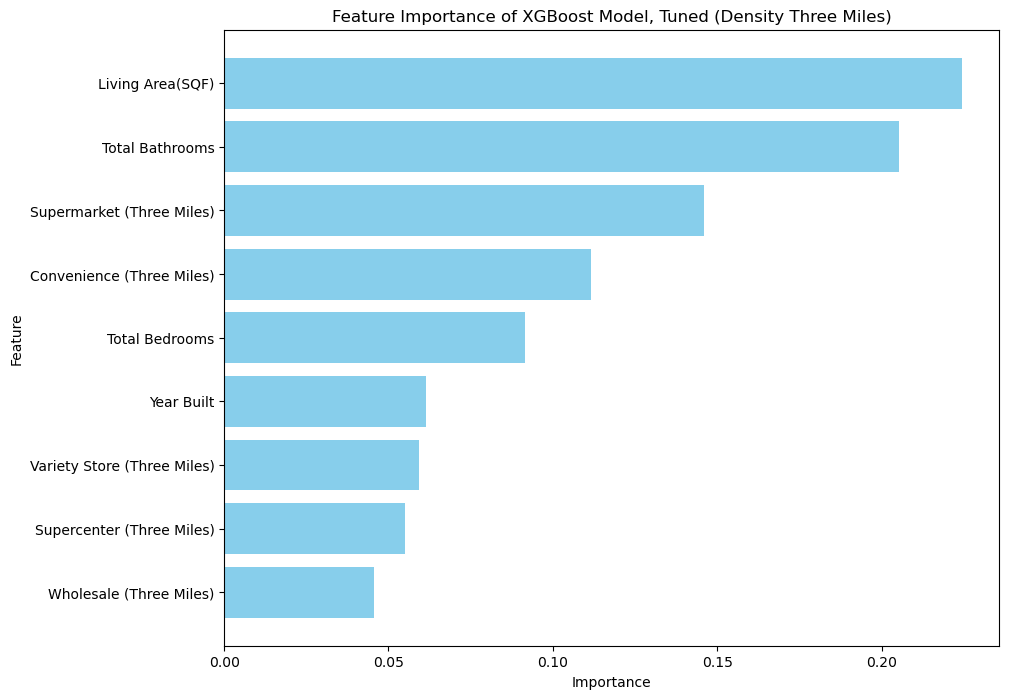

In [453]:
# Create a bar chart for feature importance
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names_three, sorted_feature_importances_three, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of XGBoost Model, Tuned (Density Three Miles)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

#The feature importance scores remain consistent regardless of the dataset.

In [454]:
all_feature_names_three #Again, just a reminder for the next part

['Year Built',
 'Total Bedrooms',
 'Living Area(SQF)',
 'Wholesale (Three Miles)',
 'Variety Store (Three Miles)',
 'Supermarket (Three Miles)',
 'Supercenter (Three Miles)',
 'Convenience (Three Miles)',
 'Total Bathrooms']

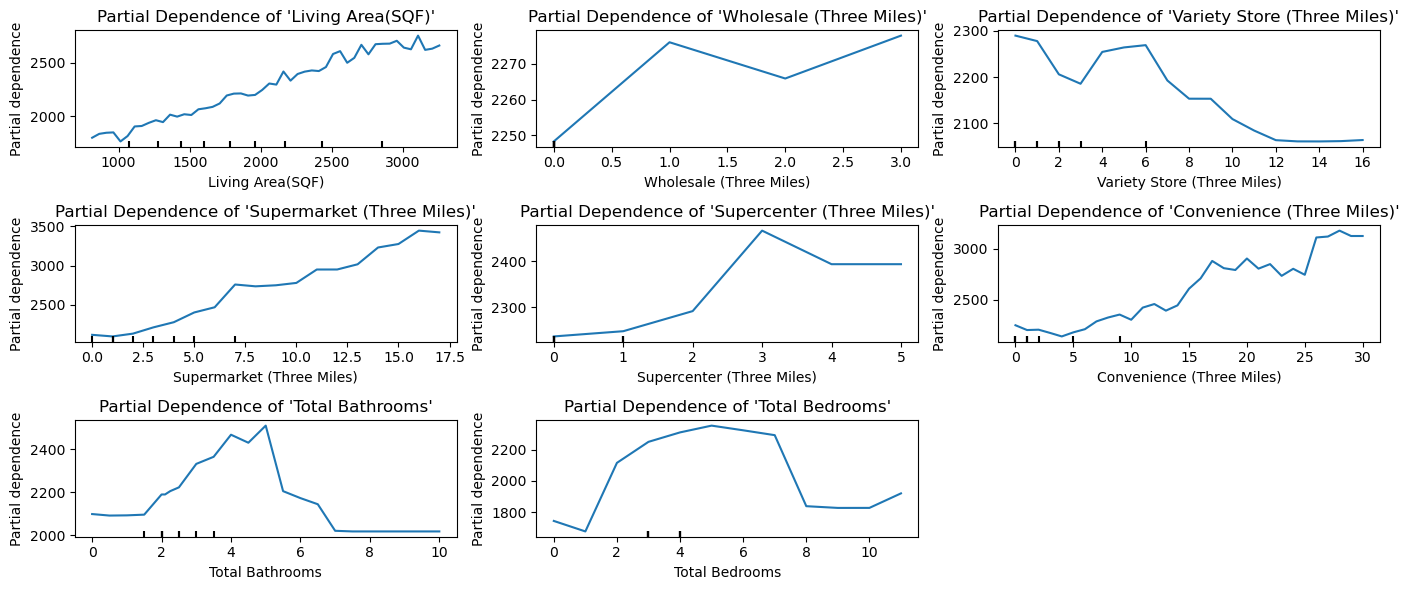

In [455]:
# List of features to include in the Partial Dependence Plots
features = [
'Living Area(SQF)', 'Wholesale (Three Miles)', 'Variety Store (Three Miles)', 'Supermarket (Three Miles)', 
    'Supercenter (Three Miles)', 'Convenience (Three Miles)', 'Total Bathrooms', 'Total Bedrooms']

# Set the number of rows and columns for the grid
n_features = len(features)
n_cols = 3  # Number of columns in the grid
n_rows = math.ceil(n_features / n_cols)  # Number of rows

# Create subplots in a grid layout
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, n_rows * 2))

# Flatten axes for easy iteration
axes = axes.ravel()

# Loop through each feature and plot
for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        best_model_three,
        X_train_val_three,  # train-val data
        [feature],
        grid_resolution=50,
        ax=axes[i]
    )
    axes[i].set_title(f"Partial Dependence of '{feature}'")  # Set title for each plot

# Hide any empty subplots (if n_features is not a perfect square)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [456]:
'''Now that both the one mile and three miles datasets are completed, we can do the same setup for the five miles dataset.
If the trend continues, it should be expected that the scores should increase overall.'''

#We have to drop the one mile and three miles features from the main dataset, and create a new five miles dataset.
Atlanta_Density_Five = Atlanta_Density.drop(columns=['Wholesale (One Mile)', 'Variety Store (One Mile)', 'Supermarket (One Mile)', 'Supercenter (One Mile)', 'Convenience (One Mile)',
                                                    'Wholesale (Three Miles)', 'Variety Store (Three Miles)','Supermarket (Three Miles)','Supercenter (Three Miles)', 'Convenience (Three Miles)'])

#As before, we have a new set of numeric features, so these features must be scaled. As an alternative, we could have scaled everything at once and then made one preprocessor, but three seperate transformed datasets
#We chose this as an example because it's easier to visualize and walkthrough. 
numeric_features_five = Atlanta_Density_Five.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns

# Combined preprocessor for numeric
preprocessor_five = ColumnTransformer(
    transformers=[
        ('num5', numeric_transformer, numeric_features_five),
])

#Apply preprocessor to original data. Again, not necessary, but it would need to be done again because there's new features.
transformed_data_five = preprocessor_five.fit_transform(Atlanta_Density_Five)

In [457]:
# Combine all feature names
all_feature_names_five = list(numeric_features_five)

#Create the five miles data frame. 
transformed_df_five = pd.DataFrame(transformed_data_five, columns=all_feature_names_five)

In [458]:
# Define the full model pipeline including the preprocessor
pipeline_five = Pipeline([
    ('preprocessor5', preprocessor_five),
    ('regressor', xgb_model)
])

#We need new variables and to fit them on the new pipeline. 
#Again, an alternative way would have been to make one pipeline and three different dataframes, which would come into play here, where you would use the transformed dataframe containing only the five mile features.
X_five = Atlanta_Density_Five.drop(columns='current_listing_price')
y_five = Atlanta_Density_Five['current_listing_price']

X_train_val_five, X_test_five, y_train_val_five, y_test_five = train_test_split(X_five, y_five, test_size=0.2, random_state=42)
X_train_five, X_val_five, y_train_five, y_val_five = train_test_split(X_train_val_five, y_train_val_five, test_size=0.25, random_state=42)

# Fit the model pipeline
pipeline_five.fit(X_train_five, y_train_five)

Pipeline(steps=[('preprocessor5',
                 ColumnTransformer(transformers=[('num5',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)',
       'Convenience (Five Miles)', 'Supercenter (Five Miles)',
       'Supermarket (Five Miles)', 'Variety Store (Five Miles)',
       'Wholesale (Five Miles)', 'Total Bathrooms'],
      dtyp...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [459]:
#Our previous scores were Validation 0.4383291006088257 and Test 0.4894154667854309 for one mile.
#And Validation 0.5902328491210938 and Test 0.5791043043136597 for five miles, for comparison. While not as jarring as a difference, it's still an increase.

val_score_five = pipeline_five.score(X_val_five, y_val_five)
print('Validation R^2:', val_score_five)

test_score_five = pipeline_five.score(X_test_five, y_test_five)
print('Test R^2:', test_score_five)

Validation R^2: 0.6277871131896973
Test R^2: 0.6108308434486389


In [460]:
#The grid has to be changed because the values changed.
param_grid_five = {
    'regressor__n_estimators': [400],       
    'regressor__learning_rate': [0.1],     
    'regressor__max_depth': [4],                
    'regressor__subsample': [0.7],               
    'regressor__colsample_bytree': [0.7],        
    'regressor__alpha': [5],
    'regressor__lambda': [5]               
}

grid_search_five = GridSearchCV(pipeline_five,
                           param_grid_five,
                           cv=kf,
                           scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],# Multiple scoring
                           refit='r2',
                           n_jobs=-1)

grid_search_five.fit(X_train_five, y_train_five)

best_model_five = grid_search_five.best_estimator_

# Access the results
results_five = grid_search_five.cv_results_
print("Best parameters:", grid_search_five.best_params_)
print("Best R^2:", grid_search_five.best_score_)

Best parameters: {'regressor__alpha': 5, 'regressor__colsample_bytree': 0.7, 'regressor__lambda': 5, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 4, 'regressor__n_estimators': 400, 'regressor__subsample': 0.7}
Best R^2: 0.5985860526561737


In [461]:
#These results would make this model the highest scoring model for XGBoost. Interestingly, the validation set has a higher score. 
best_model_five.fit(X_train_val_five, y_train_val_five)

y_val_pred_tuned_five = best_model_five.predict(X_val_five)
val_scores_five = calculate_scores(y_val_five, y_val_pred_tuned_five)

y_test_pred_tuned_five = best_model_five.predict(X_test_five)
test_scores_five = calculate_scores(y_test_five, y_test_pred_tuned_five)

y_combined_pred_tuned_five = best_model_five.predict(X_train_val_five)
combined_scores_five = calculate_scores(y_train_val_five, y_combined_pred_tuned_five)

print("Tuned Five Miles Validation Set Scores:")
print(f"R²: {val_scores_five[0]:.4f}")
print(f"MSE: {val_scores_five[1]:.4f}")
print(f"MAPE: {val_scores_five[2]:.4f}")
print(f"RMSE: {val_scores_five[3]:.4f}")

print("\nTuned Five Miles Test Set Scores:")
print(f"R²: {test_scores_five[0]:.4f}")
print(f"MSE: {test_scores_five[1]:.4f}")
print(f"MAPE: {test_scores_five[2]:.4f}")
print(f"RMSE: {test_scores_five[3]:.4f}")

print("\nTuned Five Miles Train-Val Set Scores:")
print(f"R²: {combined_scores_five[0]:.4f}")
print(f"MSE: {combined_scores_five[1]:.4f}")
print(f"MAPE: {combined_scores_five[2]:.4f}")
print(f"RMSE: {combined_scores_five[3]:.4f}")

Tuned Five Miles Validation Set Scores:
R²: 0.7497
MSE: 234024.0497
MAPE: 0.1287
RMSE: 483.7603

Tuned Five Miles Test Set Scores:
R²: 0.6307
MSE: 311078.9243
MAPE: 0.1417
RMSE: 557.7445

Tuned Five Miles Train-Val Set Scores:
R²: 0.7382
MSE: 215139.6725
MAPE: 0.1265
RMSE: 463.8315


In [462]:
best_xgb_model_five = best_model_five.named_steps['regressor']
feature_importances_five = best_xgb_model_five.feature_importances_
sorted_indices_five = np.argsort(feature_importances_five)[::-1]
sorted_feature_importances_five = feature_importances_five[sorted_indices_five]
sorted_feature_names_five = np.array(all_feature_names_five)[sorted_indices_five]
for name, importance in zip(sorted_feature_names_five, sorted_feature_importances_five):
    print(f"Feature: {name}, Importance: {importance:.4f}")

Feature: Living Area(SQF), Importance: 0.2132
Feature: Total Bathrooms, Importance: 0.1955
Feature: Supermarket (Five Miles), Importance: 0.1580
Feature: Convenience (Five Miles), Importance: 0.1074
Feature: Wholesale (Five Miles), Importance: 0.0825
Feature: Total Bedrooms, Importance: 0.0803
Feature: Variety Store (Five Miles), Importance: 0.0565
Feature: Supercenter (Five Miles), Importance: 0.0535
Feature: Year Built, Importance: 0.0533


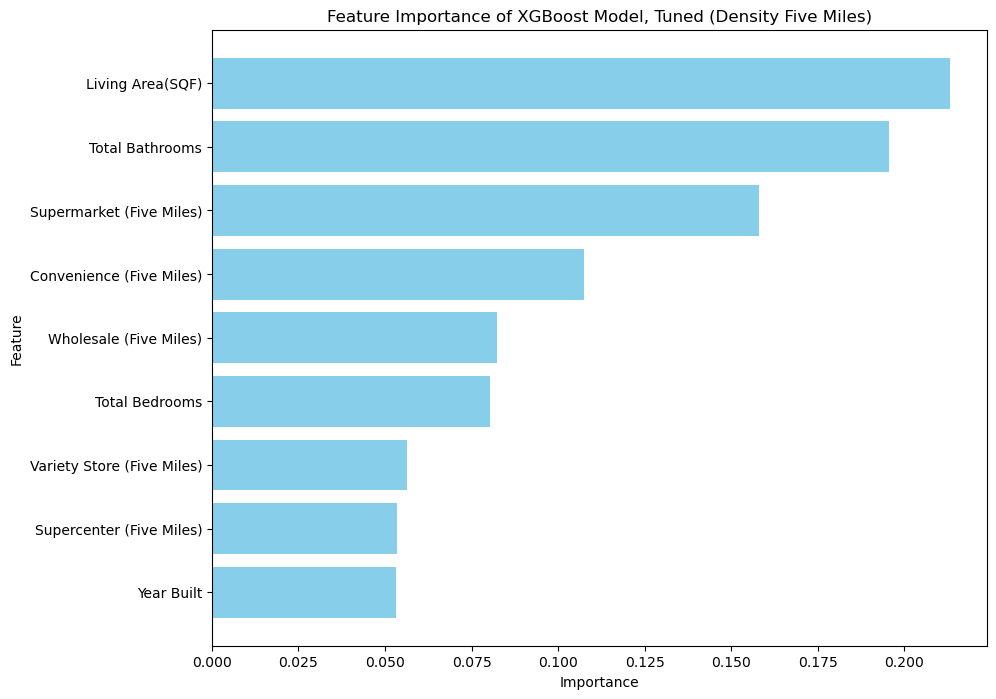

In [463]:
# Create a bar chart for feature importance
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names_five, sorted_feature_importances_five, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of XGBoost Model, Tuned (Density Five Miles)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

#The feature importance scores remain consistent regardless of the dataset.

In [464]:
all_feature_names_five #Repeated again for clarity

['Year Built',
 'Total Bedrooms',
 'Living Area(SQF)',
 'Convenience (Five Miles)',
 'Supercenter (Five Miles)',
 'Supermarket (Five Miles)',
 'Variety Store (Five Miles)',
 'Wholesale (Five Miles)',
 'Total Bathrooms']

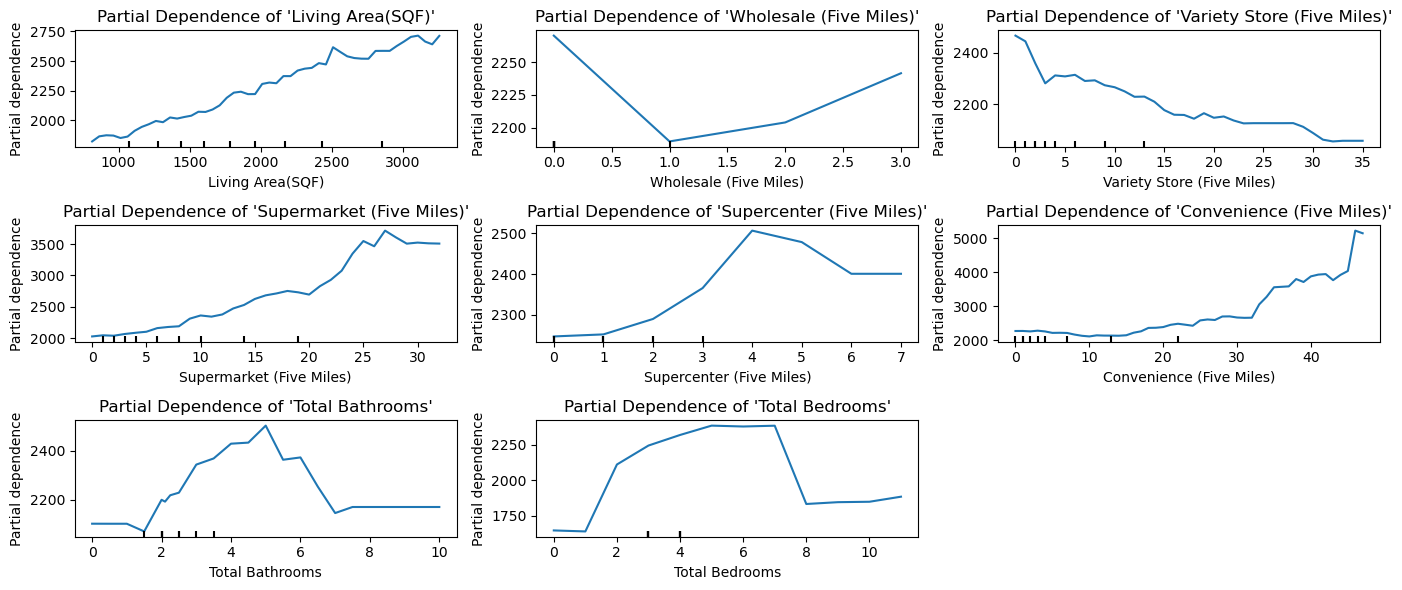

In [465]:
# List of features to include in the Partial Dependence Plots
features = [
 'Living Area(SQF)', 'Wholesale (Five Miles)', 'Variety Store (Five Miles)', 'Supermarket (Five Miles)', 
    'Supercenter (Five Miles)', 'Convenience (Five Miles)', 'Total Bathrooms', 'Total Bedrooms']

# Set the number of rows and columns for the grid
n_features = len(features)
n_cols = 3  # Number of columns in the grid
n_rows = math.ceil(n_features / n_cols)  # Number of rows

# Create subplots in a grid layout
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, n_rows * 2))

# Flatten axes for easy iteration
axes = axes.ravel()

# Loop through each feature and plot
for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        best_model_five,
        X_train_val_five,  # train-val data
        [feature],
        grid_resolution=50,
        ax=axes[i]
    )
    axes[i].set_title(f"Partial Dependence of '{feature}'")  # Set title for each plot

# Hide any empty subplots (if n_features is not a perfect square)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()